# Text Sentiment Analysis with Neural Networks

This notebook demonstrates sentiment analysis using PyTorch, including:

- Text preprocessing and tokenization
- Word embeddings for text representation
- Building and training a sentiment classifier
- Interactive sentiment analysis of user text input
- Visualization of sentiment scores


In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Download NLTK resources
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
print(nltk.data.path)
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

['C:\\Users\\super/nltk_data', 'c:\\Users\\super\\miniconda3\\envs\\pyt12\\nltk_data', 'c:\\Users\\super\\miniconda3\\envs\\pyt12\\share\\nltk_data', 'c:\\Users\\super\\miniconda3\\envs\\pyt12\\lib\\nltk_data', 'C:\\Users\\super\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1️⃣ Sample Dataset for Sentiment Analysis

We'll create a simple dataset with labeled text for positive, negative, and neutral sentiment.


,Text,Sentiment,Sentiment_Label
0,"I love this product, it works perfectly!",2,Positive
1,The service was excellent and staff were very ...,2,Positive
2,"Best experience ever, would highly recommend!",2,Positive
3,This made my day! So happy with my purchase.,2,Positive
4,Fantastic features and great user experience.,2,Positive
5,Super impressed with the quality and attention...,2,Positive
6,"Brilliant product, exceeded all my expectations!",2,Positive
7,Very satisfied with how quickly it arrived.,2,Positive
8,Amazing value for money and great performance.,2,Positive
9,"Delighted with this, it's exactly what I needed.",2,Positive


C:\Users\super\AppData\Local\Temp\ipykernel_53076\1705157560.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment_Label", data=df, palette=["red", "gray", "green"])


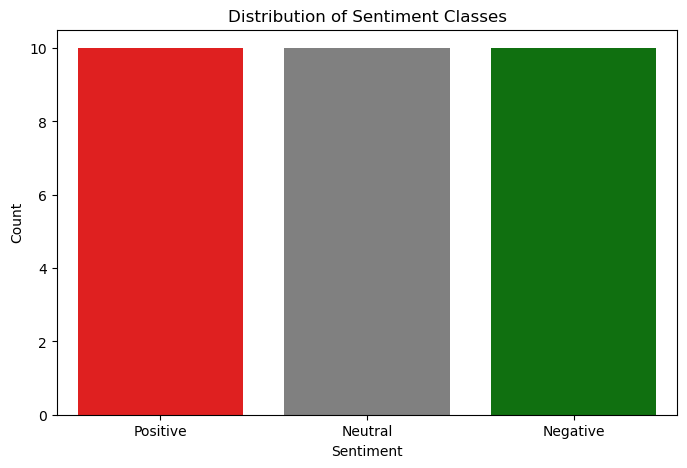

In [19]:
# Create a sample dataset with text and sentiment labels
# 0 = Negative, 1 = Neutral, 2 = Positive
data = [
    # Positive examples
    ("I love this product, it works perfectly!", 2),
    ("The service was excellent and staff were very friendly.", 2),
    ("Best experience ever, would highly recommend!", 2),
    ("This made my day! So happy with my purchase.", 2),
    ("Fantastic features and great user experience.", 2),
    ("Super impressed with the quality and attention to detail.", 2),
    ("Brilliant product, exceeded all my expectations!", 2),
    ("Very satisfied with how quickly it arrived.", 2),
    ("Amazing value for money and great performance.", 2),
    ("Delighted with this, it's exactly what I needed.", 2),
    # Neutral examples
    ("The product arrived on time and works as described.", 1),
    ("Average performance, nothing special to mention.", 1),
    ("It's okay for the price, does what it needs to do.", 1),
    ("Standard features, similar to other products available.", 1),
    ("The service was as expected, no issues to report.", 1),
    ("Neither impressed nor disappointed, just standard.", 1),
    ("Some good and bad points, balances out overall.", 1),
    ("Reasonable quality for the price point.", 1),
    ("Got what I paid for, nothing more or less.", 1),
    ("Does the job but doesn't stand out in any way.", 1),
    # Negative examples
    ("Terrible experience, would not recommend at all.", 0),
    ("The product broke after one week, very disappointed.", 0),
    ("Poor customer service and slow delivery times.", 0),
    ("Not worth the money, many better alternatives available.", 0),
    ("Frustrated with how difficult it was to use.", 0),
    ("Bad quality and poor design, avoid this product.", 0),
    ("Completely useless for its intended purpose.", 0),
    ("Waste of money, doesn't work as advertised.", 0),
    ("Annoyed with the lack of features promised.", 0),
    ("Unhappy with my purchase, will be returning it.", 0),
]

# Convert to DataFrame for easier visualization
df = pd.DataFrame(data, columns=["Text", "Sentiment"])
df["Sentiment_Label"] = df["Sentiment"].map({0: "Negative", 1: "Neutral", 2: "Positive"})

# Display the dataset
display(HTML("<h3>Sentiment Analysis Dataset:</h3>"))
display(df.head(10))

# Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="Sentiment_Label", data=df, palette=["red", "gray", "green"])
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

## 2️⃣ Text Preprocessing

We'll clean and tokenize the text data to prepare it for the model.


In [ ]:
def preprocess_text(text):
    # Make sure NLTK resources are available
    try:
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r"[^a-zA-Z\s]", "", text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words("english"))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return tokens
    except LookupError:
        # If there's an issue with NLTK resources, download them again
        print("Downloading required NLTK resources...")
        nltk.download("punkt")
        nltk.download("stopwords")
        nltk.download("wordnet")

        # Try again after downloading
        text = text.lower()
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words("english"))
        tokens = [token for token in tokens if token not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return tokens


# Apply preprocessing to the dataset


df["Processed_Text"] = df["Text"].apply(preprocess_text)



# Display a few examples of processed text


display(HTML("<h3>Preprocessed Text Examples:</h3>"))


display_df = df[["Text", "Processed_Text", "Sentiment_Label"]].head(5)


display(display_df)

,Text,Processed_Text,Sentiment_Label
0,"I love this product, it works perfectly!","[love, product, work, perfectly]",Positive
1,The service was excellent and staff were very ...,"[service, excellent, staff, friendly]",Positive
2,"Best experience ever, would highly recommend!","[best, experience, ever, would, highly, recomm...",Positive
3,This made my day! So happy with my purchase.,"[made, day, happy, purchase]",Positive
4,Fantastic features and great user experience.,"[fantastic, feature, great, user, experience]",Positive


## 3️⃣ Building Vocabulary and Tokenization

Create a vocabulary from all processed texts and convert words to numerical tokens.


In [21]:
# Build vocabulary from all processed texts
all_words = [word for tokens in df["Processed_Text"] for word in tokens]
vocab = sorted(set(all_words))

# Create word-to-index and index-to-word mappings
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve 0 for padding
word_to_idx["<PAD>"] = 0  # Padding token
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Display vocabulary size
print(f"Vocabulary size: {len(word_to_idx)} words")

# Display a sample of the vocabulary
vocab_df = pd.DataFrame(list(word_to_idx.items())[:20], columns=["Word", "Index"])
display(HTML("<h3>Vocabulary Sample (first 20 words):</h3>"))
display(vocab_df)


# Function to convert text to token sequences
def text_to_sequence(tokens, word_to_idx, max_length=20):
    # Convert tokens to indices
    sequence = [word_to_idx.get(word, 0) for word in tokens]

    # Truncate or pad sequence to fixed length
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence = sequence + [0] * (max_length - len(sequence))

    return sequence


# Apply tokenization
MAX_LENGTH = 20
df["Token_Sequence"] = df["Processed_Text"].apply(
    lambda x: text_to_sequence(x, word_to_idx, MAX_LENGTH)
)

# Display example of tokenized text
display(HTML("<h3>Tokenized Text Example:</h3>"))
example_idx = 0
example_text = df.iloc[example_idx]["Text"]
example_processed = df.iloc[example_idx]["Processed_Text"]
example_tokens = df.iloc[example_idx]["Token_Sequence"]

print(f"Original text: '{example_text}'")
print(f"Processed tokens: {example_processed}")
print(f"Numerical tokens: {example_tokens}")

Vocabulary size: 99 words


,Word,Index
0,advertised,1
1,alternative,2
2,amazing,3
3,annoyed,4
4,arrived,5
5,attention,6
6,available,7
7,average,8
8,avoid,9
9,bad,10


Original text: 'I love this product, it works perfectly!'
Processed tokens: ['love', 'product', 'work', 'perfectly']
Numerical tokens: [49, 67, 96, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 4️⃣ Prepare Dataset for Training

Split the data into training and testing sets and create PyTorch datasets.


In [22]:
# Create feature and target arrays
X = np.array(df["Token_Sequence"].tolist())
y = np.array(df["Sentiment"].tolist())

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


# Create PyTorch dataset
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Create training and testing datasets
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Training samples: 24
Testing samples: 6


## 5️⃣ Build Sentiment Analysis Model

Create a neural network model for sentiment classification using LSTM architecture.


In [23]:
class SentimentAnalysisModel(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout
    ):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
        )

        # Output layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text shape: [batch size, sequence length]

        # Apply embedding layer
        embedded = self.embedding(text)
        # embedded shape: [batch size, sequence length, embedding dim]

        # Pass through LSTM
        output, (hidden, cell) = self.lstm(embedded)
        # hidden shape: [n layers * n directions, batch size, hidden dim]

        # If bidirectional, concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        # hidden shape: [batch size, hidden dim * n directions]

        # Apply dropout
        hidden = self.dropout(hidden)

        # Pass through linear layer
        return self.fc(hidden)


# Initialize model with hyperparameters
VOCAB_SIZE = len(word_to_idx)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3  # 3 sentiment classes (negative, neutral, positive)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = SentimentAnalysisModel(
    VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT
)

# Display model architecture
display(HTML(f"<h3>Model Architecture:</h3>"))
display(HTML(f"<pre>{model}</pre>"))

## 6️⃣ Model Training

Train the sentiment analysis model on our dataset.


In [24]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Training function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        # Get batch data
        text, labels = batch

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(text)

        # Calculate loss
        loss = criterion(predictions, labels)

        # Calculate accuracy
        predictions = torch.argmax(predictions, dim=1)
        correct = (predictions == labels).float().sum()
        accuracy = correct / len(labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()

    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            predictions = model(text)
            loss = criterion(predictions, labels)

            predictions = torch.argmax(predictions, dim=1)
            correct = (predictions == labels).float().sum()
            accuracy = correct / len(labels)

            epoch_loss += loss.item()
            epoch_acc += accuracy.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


# Train the model
N_EPOCHS = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(N_EPOCHS):
    # Train model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate model
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:.2f}%")

Epoch 1/20
	Train Loss: 1.100 | Train Acc: 33.33%
	Val. Loss: 1.090 | Val. Acc: 66.67%
Epoch 2/20
	Train Loss: 1.087 | Train Acc: 41.67%
	Val. Loss: 1.092 | Val. Acc: 33.33%
Epoch 3/20
	Train Loss: 1.060 | Train Acc: 70.83%
	Val. Loss: 1.095 | Val. Acc: 33.33%
Epoch 4/20
	Train Loss: 1.033 | Train Acc: 70.83%
	Val. Loss: 1.097 | Val. Acc: 33.33%
Epoch 5/20
	Train Loss: 0.997 | Train Acc: 91.67%
	Val. Loss: 1.099 | Val. Acc: 33.33%
Epoch 6/20
	Train Loss: 0.946 | Train Acc: 87.50%
	Val. Loss: 1.104 | Val. Acc: 33.33%
Epoch 7/20
	Train Loss: 0.888 | Train Acc: 100.00%
	Val. Loss: 1.109 | Val. Acc: 16.67%
Epoch 8/20
	Train Loss: 0.806 | Train Acc: 95.83%
	Val. Loss: 1.121 | Val. Acc: 33.33%
Epoch 9/20
	Train Loss: 0.700 | Train Acc: 95.83%
	Val. Loss: 1.145 | Val. Acc: 33.33%
Epoch 10/20
	Train Loss: 0.558 | Train Acc: 100.00%
	Val. Loss: 1.202 | Val. Acc: 33.33%
Epoch 11/20
	Train Loss: 0.330 | Train Acc: 100.00%
	Val. Loss: 1.353 | Val. Acc: 16.67%
Epoch 12/20
	Train Loss: 0.147 | Train

## 7️⃣ Visualize Training Progress

Plot loss and accuracy curves to understand model training.


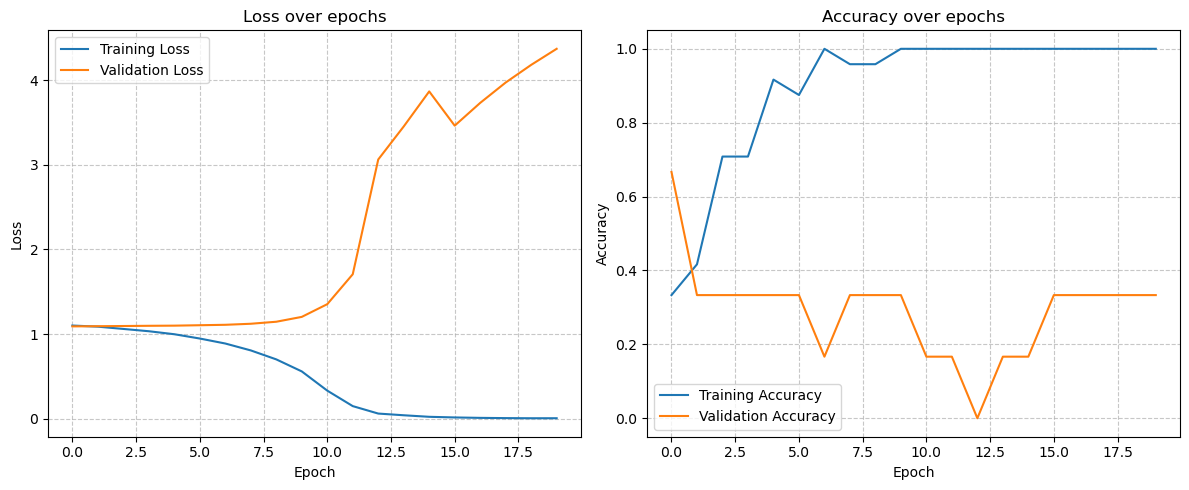

In [25]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## 8️⃣ Sentiment Analysis Function

Create a function to analyze the sentiment of any text input.


In [26]:
def analyze_sentiment(model, text, word_to_idx, max_length=20):
    model.eval()

    # Preprocess text
    tokens = preprocess_text(text)

    # Convert to sequence
    sequence = text_to_sequence(tokens, word_to_idx, max_length)

    # Convert to tensor
    sequence_tensor = torch.tensor([sequence], dtype=torch.long)

    # Get prediction
    with torch.no_grad():
        prediction = model(sequence_tensor)
        probabilities = F.softmax(prediction, dim=1)
        sentiment_class = torch.argmax(probabilities, dim=1).item()

    # Map class to sentiment
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = sentiment_map[sentiment_class]

    # Get probability scores
    probability_scores = {
        "Negative": probabilities[0][0].item(),
        "Neutral": probabilities[0][1].item(),
        "Positive": probabilities[0][2].item(),
    }

    return sentiment, probability_scores


# Test the sentiment analysis function with some examples
test_sentences = [
    "This product is amazing and works perfectly!",
    "It's okay I guess, nothing special.",
    "Terrible service, would never buy again.",
    "I really enjoyed this experience, highly recommended!",
    "Not sure if I like it or not, has both pros and cons.",
]

results = []
for sentence in test_sentences:
    sentiment, scores = analyze_sentiment(model, sentence, word_to_idx)
    results.append(
        {
            "Text": sentence,
            "Sentiment": sentiment,
            "Negative Score": f"{scores['Negative']:.3f}",
            "Neutral Score": f"{scores['Neutral']:.3f}",
            "Positive Score": f"{scores['Positive']:.3f}",
        }
    )

# Display results in a table
results_df = pd.DataFrame(results)
display(HTML("<h3>Sentiment Analysis Examples:</h3>"))
display(results_df)

,Text,Sentiment,Negative Score,Neutral Score,Positive Score
0,This product is amazing and works perfectly!,Positive,0.001,0.001,0.998
1,"It's okay I guess, nothing special.",Neutral,0.001,0.998,0.001
2,"Terrible service, would never buy again.",Negative,0.997,0.001,0.001
3,"I really enjoyed this experience, highly recom...",Positive,0.001,0.001,0.997
4,"Not sure if I like it or not, has both pros an...",Positive,0.001,0.002,0.997


## 9️⃣ Visualize Sentiment Scores

Create a visualization for sentiment scores to better understand model predictions.


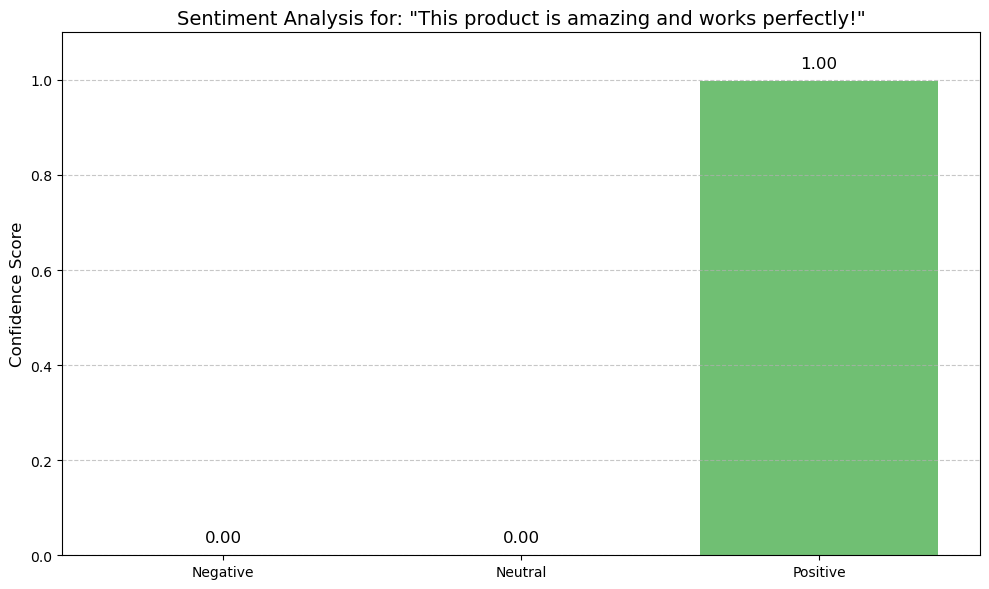

In [27]:
def plot_sentiment_scores(text, scores):
    # Create a figure
    plt.figure(figsize=(10, 6))

    # Colors for sentiments
    colors = ["#FF6B6B", "#ADADAD", "#4CAF50"]

    # Create bar chart
    sentiments = ["Negative", "Neutral", "Positive"]
    values = [scores[sentiment] for sentiment in sentiments]

    bars = plt.bar(sentiments, values, color=colors, alpha=0.8)

    # Add text labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.02,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=12,
        )

    # Add title and labels
    plt.title(f'Sentiment Analysis for: "{text}"', fontsize=14)
    plt.ylabel("Confidence Score", fontsize=12)
    plt.ylim(0, 1.1)  # Set y-axis limit

    # Add grid for better readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Test the visualization with an example
example_text = "This product is amazing and works perfectly!"
sentiment, scores = analyze_sentiment(model, example_text, word_to_idx)
plot_sentiment_scores(example_text, scores)

## 1️⃣0️⃣ Interactive Sentiment Analyzer

Create an interactive widget to analyze user text input and display sentiment with confidence scores.


In [ ]:
from ipywidgets import widgets
from IPython.display import display, clear_output

# Create input widget
text_input = widgets.Textarea(
    value="",
    placeholder="Type some text to analyze its sentiment...",
    description="Text:",
    disabled=False,
    layout=widgets.Layout(width="90%", height="100px"),
)

analyze_button = widgets.Button(
    description="Analyze Sentiment",
    button_style="primary",
    tooltip="Click to analyze sentiment",
    icon="check",
)

output = widgets.Output()


# Create a gauge visualization for sentiment scores
def create_gauge(score, sentiment, color):
    # Convert score to percentage for gauge
    percentage = int(score * 100)

    # Create HTML for gauge
    gauge_html = f"""
    <div style="margin: 10px; text-align: center;">
        <div style="font-weight: bold; margin-bottom: 5px;">{sentiment}</div>
        <div style="width: 150px; height: 20px; background-color: #e0e0e0; border-radius: 10px; overflow: hidden;">
            <div style="width: {percentage}%; height: 100%; background-color: {color};"></div>
        </div>
        <div style="margin-top: 5px;">{percentage}%</div>
    </div>
    """
    return gauge_html


# Function to handle button click
def on_analyze_button_clicked(b):
    with output:
        clear_output()

        # Get text from input
        text = text_input.value.strip()

        if not text:
            print("Please enter some text to analyze.")
            return

        # Analyze sentiment
        sentiment, scores = analyze_sentiment(model, text, word_to_idx)

        # Display formatted results with gauges
        html_output = f"""
        <div style="padding: 10px; border: 1px solid #ddd; border-radius: 10px; background-color: #f9f9f9;">
            <h3>Sentiment Analysis Result:</h3>
            <p><b>Text:</b> "{text}"</p>
            <p><b>Overall Sentiment:</b> <span style="font-size: 1.2em; font-weight: bold; color: 
                {'#FF6B6B' if sentiment == 'Negative' else '#4CAF50' if sentiment == 'Positive' else '#ADADAD'};">
                {sentiment}</span>
            </p>
            <h4>Confidence Scores:</h4>
            <div style="display: flex; justify-content: space-around;">
                {create_gauge(scores['Negative'], 'Negative', '#FF6B6B')}
                {create_gauge(scores['Neutral'], 'Neutral', '#ADADAD')}
                {create_gauge(scores['Positive'], 'Positive', '#4CAF50')}
            </div>
        </div>
        """

        display(HTML(html_output))

        # Also show the visualization
        plot_sentiment_scores(text, scores)


# Link button click to function
analyze_button.on_click(on_analyze_button_clicked)

# Display widgets
display(HTML("<h2>📊 Interactive Sentiment Analyzer</h2>"))
display(
    HTML(
        "<p>Enter text below to analyze its sentiment. The model will classify it as positive, negative, or neutral.</p>"
    )
)
display(text_input, analyze_button, output)

Textarea(value='', description='Text:', layout=Layout(height='100px', width='90%'), placeholder='Type some tex…

Button(button_style='primary', description='Analyze Sentiment', icon='check', style=ButtonStyle(), tooltip='Cl…

Output()

## 1️⃣1️⃣ Conclusion and Next Steps

In this notebook, we've built a sentiment analysis model that can classify text as positive, negative, or neutral. Here's what we've learned:

- How to preprocess and tokenize text data
- How to build a vocabulary and convert words to numerical tokens
- How to create and train an LSTM model for sentiment classification
- How to visualize sentiment scores and create an interactive analyzer

**Next steps to explore:**

- Use pre-trained word embeddings (GloVe, Word2Vec) for better representation
- Experiment with different model architectures (CNN, Transformer)
- Train on a larger dataset for improved accuracy
- Add support for more fine-grained sentiment analysis beyond positive/negative/neutral
- Deploy the model as a web application for broader use


\*\*Clear Sentiment (Baseline Tests)
"This product absolutely changed my life for the better!"
"I'm returning this immediately and demanding a refund."
"It functions as described in the manual."

\*\*Mixed Sentiment (Challenge Tests)
"The quality is excellent but the price is way too high."
"Despite the poor packaging, the product itself performs wonderfully."
"Great features but terrible customer support when I needed help."

\*\*Negation Patterns
"I don't hate this product at all, actually."
"Not the worst purchase I've made this year."
"Couldn't be more disappointed with how it turned out."

\*\*Subtle/Implicit Sentiment
"Well, that was certainly an experience..."
"I've used better products in the past."
"Let's just say I won't be buying this again."

\*\*Sarcasm/Irony
"Wow, it broke after just one day. Such quality!"
"Just what I wanted - another product that doesn't work."
"If you enjoy wasting money, this is perfect for you!"

\*\*Comparative Context
"Better than the competition but still below my expectations."
"Not as good as my previous one but does the job for now."
"Average at best when compared to similar products on the market."
